
# **Initial considerations**

To run this notebook I had to rely on my laptop, since colab runs out of memory in all the stages (word2vec training and reviews rating prediction model training).

I performed the word2vec training on the raw text of the reviews, trying to capture the dependencies and correlation of the words in this specific context.

I also tried a model using keras embedding, so giving the model the raw text as array of integers, to see if my word2vec improves performances or not.

# **Importings & uploads**

In [1]:
import pandas as pd
import os
import shutil
import io
import re
import string
import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU, Dense, Input, Bidirectional, Dropout
from keras.layers.core import  Activation
import tensorflow as tf
from matplotlib import pyplot
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

In [4]:
url = 'https://raw.githubusercontent.com/Beshoy22/park_rev/main/parkReviews.csv'
reviews = pd.read_csv(url, encoding_errors='ignore')

In [5]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


# **Text tokenization**

In this section I pre-processed the raw text of the reviews, by eliminating punctuation, lowercasing all the words and handling the contractions to have a standard format.

After that I made a vocabolary with all the unique words (which went from about 100K to 42K); this is necessary to transorm my raw text into an integer vector that can be processed through skip gram to generate my embedding.

At any step I check that I didn't made any error (ex. after int trasformation I printed the trasformed vector and checked its consistency).

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
contraction_mapping = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

def handle_contractions(text): #in this function I perform the mapping of the contractions and the deleting of the punctuation and I provide as output an array of words
  translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
  words = text.split()
  processed_words = []

  for word in words:
    if word.lower() in contraction_mapping:
      processed_words.extend(contraction_mapping[word.lower()].split())
    else:
      word = word.translate(translator)
      if len(word.lower().split()) > 1:
        processed_words.extend(word.lower().split())
      else:
        processed_words.append(word.replace(" ", "").lower())

  return processed_words

In [ ]:
vocab, index = {}, 1  # start indexing from 1
vocab['<pad>'] = 0  # add a padding token

#here I create the vocab to map integers with unique words after handling contractions and punctuation
for k in range(0, len(reviews)):
  sentence = handle_contractions(reviews.loc[k].Review_Text)
  for token in sentence:
    if token not in vocab:
      vocab[token] = index
      index += 1

vocab_size = len(vocab)
print(vocab)

In [ ]:
print(vocab_size)

42591


In [ ]:
inverse_vocab = {index: token for token, index in vocab.items()}
print(inverse_vocab) #the inverse vocab will be useful to verify the correctness of the mapping between words and integers

In [ ]:
#here I replace the words with their correspondent int value
for p in range(0, len(reviews)):
  sentence = handle_contractions(reviews.loc[p].Review_Text)
  new_mapping = []
  for token in sentence:
    new_mapping.append(vocab[token])
  reviews.at[p, "Review_Text"] = new_mapping

In [ ]:
#here I verify the consistency of my operations by looking if the first review was correctly mapped
print(reviews.loc[0].Review_Text)
print(reviews.loc[0].Review_ID)

for token in reviews.loc[0].Review_Text:
  print(inverse_vocab[token], end = " ")

[1, 2, 3, 4, 5, 6, 7, 8, 2, 9, 10, 7, 11, 12, 13, 14, 15, 16, 17, 18, 2, 19, 20, 21, 22, 23, 24, 25, 13, 26, 27, 28, 29, 16, 30, 31, 25, 32, 33, 34, 35, 36, 37, 38, 39, 16, 40, 41, 42, 43, 44, 45, 37, 46, 47, 48, 16, 49, 50, 44, 51]
670772142
if you have ever been to disneyland anywhere you will find disneyland hong kong very similar in the layout when you walk into main street it has a very familiar feel one of the rides its a small world is absolutely fabulous and worth doing the day we visited was fairly hot and relatively busy but the queues moved fairly well 

# **Word embedding (word2vec)**

I ran this section on my laptop since colab run out of memory any time I tried, then I uploaded the weights of the hidden layer (my word2vec embedding) on github and I imported it in the pre-processing section.

I used the skip gram approach, which consists in training a network to predict context words given the target word, this allows to have a hidden layer that represents the target word based on its contexts.

I got accuracy of about 0.80 in the skip gram, and my embedding consists of 256 dimesions.

Afer retriving the hidden layer weights I downloaded them with the meta data and I plotted them on [this site](https://projector.tensorflow.org/?hl=it&_gl=1*99xm3p*_ga*MTQwODIzMDIzOS4xNjg4NDk0MTE0*_ga_W0YLR4190T*MTY4ODU0OTEwOS40LjEuMTY4ODU0OTE1Ni4wLjAuMA..), that uses the PCA to reduce the 256 dimesions to 3, to verify the closure between similar words.

In this section I followed the tutorial provided by tensorflow, increasing the embedding dimension from 128 to 256, the positive samples from 2 to 3 and the negative samples from 4 to 6.

In [ ]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for `vocab_size` tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in the dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples
    # with a positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=SEED,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      negative_sampling_candidates = tf.expand_dims(
          negative_sampling_candidates, 1)

      context = tf.concat([context_class, negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [ ]:
sentences = []

for c in range(0, len(reviews)):
  sentences.append(reviews.loc[c].Review_Text)

In [ ]:
targets, contexts, labels = generate_training_data(sentences, 3, 6, vocab_size, 1234)

100%|██████████| 42656/42656 [06:40<00:00, 106.63it/s]


In [ ]:
targets, contexts, labels = generate_training_data(
    sequences=sentences,
    window_size=3,
    num_ns=6,
    vocab_size=vocab_size,
    seed=1234)

targets = np.array(targets)
contexts = np.array(contexts)[:,:,0]
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|██████████| 42656/42656 [06:50<00:00, 103.79it/s] 




targets.shape: (5888394,)
contexts.shape: (5888394, 7)
labels.shape: (5888394, 7)


In [ ]:
print(targets[0:5])
print(contexts[0:5])
print(labels[100:120])
print(sentences[0:10])

[42 42 42 42 42]
[[   43 13343   279  6081 34236    42    10]
 [   40   786  2556   140     2     0    94]
 [   16    77 15692  1011     6   205     0]
 [   44  3900    89    12     0   119 14278]
 [   41    12   131     1     9 23236   779]]
[[1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[1, 2, 3, 4, 5, 6, 7, 8, 2, 9, 10, 7, 11, 12, 13, 14, 15, 16, 17, 18, 2, 19, 20, 21, 22, 23, 24, 25, 13, 26, 27, 28, 29, 16, 30, 31, 25, 32, 33, 34, 35, 36, 37, 38, 39, 16, 40, 41, 42, 43, 44, 45, 37, 46, 47, 48, 16, 49, 50, 44, 51], [31, 5, 25, 52, 53, 54, 55, 56, 41, 57, 58, 7, 59, 60, 61, 56, 41, 62, 63, 15, 64, 59, 65, 66, 67, 68, 69, 3, 70, 71, 72, 73, 54, 74, 75, 76, 71, 73, 54, 77, 78, 59, 79, 80, 73, 81,

In [ ]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=5+1)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

In [ ]:
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [ ]:
embedding_dim = 256
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [ ]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 7), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 7), dtype=tf.int64, name=None))>


In [ ]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<PrefetchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 7), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 7), dtype=tf.int64, name=None))>


In [ ]:
word2vec.fit(dataset, epochs=8, callbacks=[tensorboard_callback])

Epoch 1/8
   2/5750 [..............................] - ETA: 7:20 - loss: 1.9461 - accuracy: 0.1406 

2023-07-03 14:25:02.822784: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5750/5750 [==============================] - 450s 78ms/step - loss: 0.9943 - accuracy: 0.6462

Below I uploaded the screenshot of the epochs (this output went lost uploading the notebook on colab).

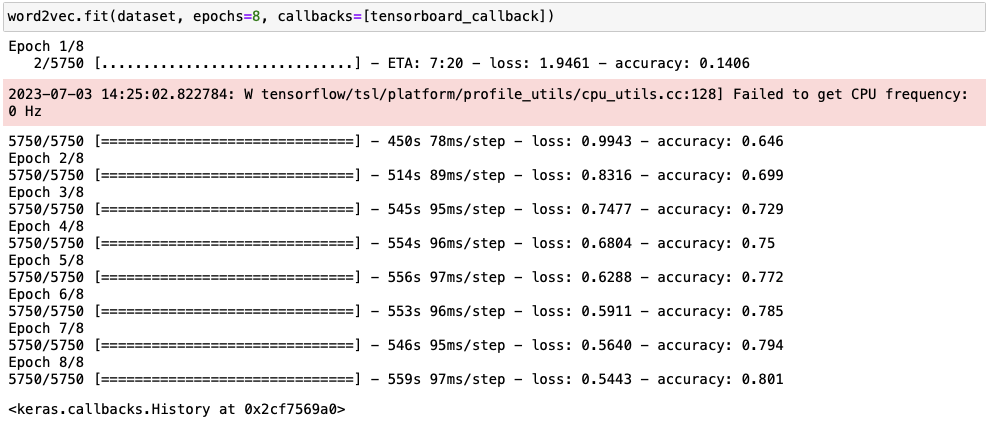

In [ ]:
weights = word2vec.get_layer('embedding').get_weights()[0]
vocab = inverse_vocab

In [ ]:
out_v = io.open('./vectors_new.tsv', 'w', encoding='utf-8')
out_m = io.open('./metadata_new.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(str(inverse_vocab[word]) + "\n")
out_v.close()
out_m.close()


# **Pre-processing**

In this section the final objective is to create a 3d tensor processable by an RNN architecture.

First thing I did was **deleting all the rows with missing values** (it reguards only year_month column), I didn't rely on an imputer since the "most frequent" strategy would only cause unnecessary "noise" in the data, while a KNN imputer is not so representative without processing the raw text; anyways there are about 2K rows with missing values, so on 42K total rows is not a problem to drop them.

After that I transformed the year_month feature in 2 separate columns and I normalized them.

Then I managed the reviewer_location and branch by transforming them in integers values.

I then dropped the review_id column that is obviously useless in the training.

I performed an **undersampling** because the first times I ran the model (before undersampling) I realized that the model had an accuracy of about 0.6 but only because having umbalanced classed (about 60% of reviews are 5 stars) it was just predicting all 5.

Then I transofrmed the integer vectors of the raw texts by substituting all the values with the correspondent embedding vectors, deleting all the reviews with more than 300 words.
In this stage I created an 2d tensor for any review and I added the year, month, rev_loc and branch as elements in the first dimesion (so the RNN will process all the words and also these features).

Last thing I did was the train test splitting keeping the same ratio between classes presence in the train and test.

In [ ]:
model_reviews = reviews

In [ ]:
#here I handle the year_month feature as specified above

Year = []
Month = []
q = 0
count = 0

for t in range(0, len(model_reviews)):
  try:
    year_month = model_reviews.loc[t].Year_Month.replace("-", " ").split()
    Year.append((int(year_month[0])-2010)/9) #since years are from 2010 to 2019, I will normalize with (year-2010)/9
    Month.append((int(year_month[1])-1)/12) #since months are from 1 to 12, I will normalize with (month-1)/11
  except: #missing values, since my dataset is pretty large is not a problem to drop them
    model_reviews = model_reviews.drop(index = t)
    count += 1

print(count)
print(len(model_reviews))

2613
40043


In [ ]:
model_reviews = model_reviews.reset_index(drop = True) #after dropping rows I perform the reset indexing otherwise iterating the dataset will occurs in error

In [ ]:
#separate year and month features

model_reviews['Year'] = Year
model_reviews['Month'] = Month
model_reviews = model_reviews.drop('Year_Month', axis=1)

In [ ]:
#handling reviewer_location and branch mapping to integers

t = 0
Locations = dict()
Branch = dict()
count_br = 0
count_loc = 0

for t in range(0, len(model_reviews)):
  br = model_reviews.loc[t].Branch
  loc = model_reviews.loc[t].Reviewer_Location
  if br in Branch:
    model_reviews.at[t, "Branch"] = Branch[br]
  else:
    Branch[br] = count_br
    count_br += 1
    model_reviews.at[t, "Branch"] = Branch[br]
  if loc in Locations:
    model_reviews.at[t, "Reviewer_Location"] = Locations[loc]
  else:
    Locations[loc] = count_loc
    count_loc += 1
    model_reviews.at[t, "Reviewer_Location"] = Locations[loc]


In [ ]:
model_reviews

Review_ID  Rating Reviewer_Location  \
0      670772142       4                 0   
1      670682799       4                 1   
2      670623270       4                 2   
3      670607911       4                 0   
4      670607296       4                 3   
...          ...     ...               ...   
40038   92198076       4                 3   
40039   92061774       4                54   
40040   91995748       1                 3   
40041   91984642       2                 3   
40042   91827418       5                 3   

                                             Review_Text Branch      Year  \
0      [1, 2, 3, 4, 5, 6, 7, 8, 2, 9, 10, 7, 11, 12, ...      0  1.000000   
1      [31, 5, 25, 52, 53, 54, 55, 56, 41, 57, 58, 7,...      0  1.000000   
2      [164, 165, 23, 166, 167, 168, 45, 96, 168, 169...      0  1.000000   
3      [58, 7, 34, 25, 79, 239, 131, 186, 175, 34, 22...      0  1.000000   
4      [16, 275, 34, 176, 15, 16, 276, 277, 180, 113,...      0  1.000000   
...                                                  ...    ...       ...   
40038  [213, 487, 3719, 405, 43, 9131, 16, 1054, 1725...      2  0.111111   
40039  [124, 3998, 122, 25, 516, 502, 524, 731, 6, 7,...      2  0.111111   
40040  [41, 485, 16, 630, 2777, 6264, 15, 16, 126, 13...      2  0.000000   
40041  [51, 99, 43, 150, 2075, 2141, 6, 61, 731, 393,...      2  0.000000   
40042  [1, 929, 184, 25, 126, 780, 657, 159, 990, 29,...      2  0.000000   

          Month  
0      0.250000  
1      0.333333  
2      0.250000  
3      0.250000  
4      0.250000  
...         ...  
40038  0.000000  
40039  0.000000  
40040  0.916667  
40041  0.916667  
40042  0.666667  

[40043 rows x 7 columns]

In [ ]:
model_reviews_t = model_reviews.drop('Review_ID', axis=1)

Checking the class distribution to perform a custom undersampling, since the default one will give only 6K (less frequent class counting * num of classes) rows.

In [ ]:
class_distr = {1: 0, 2: 0, 3: 0, 4: 0, 5:0}
rating_t = model_reviews.pop('Rating')

In [ ]:
for rat in rating_t:
    class_distr[int(rat)] += 1

In [ ]:
class_distr

{1: 1338, 2: 1929, 3: 4782, 4: 10086, 5: 21908}

After many tries, the best undersampling I found is the one in this mapping, previously I tried the deafult one and I tried with {1:1338, 2:1929, 3:4782, 4:10086, 5:10086} but I run in underfitting and the models were only giving 4 and 5 as predictions.

In [ ]:
sampling_strategy = {1:1338, 2:1929, 3:4782, 4:5000, 5:5000}

rand_und_samp = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=22)

model_reviews, rating = rand_und_samp.fit_resample(model_reviews_t, rating_t)

In [ ]:
#here I count how many reviews I have with more than 300 words, to then determine my 3d tensor dimensions

k = 0
count_l300 = 0

for k in range(0, len(model_reviews)):
  if len(model_reviews.loc[k].Review_Text) > 300:
    count_l300 += 1

print(count_l300)

1895


In [7]:
#here i retrieve the word2vec embedding

url_vec = 'https://github.com/Beshoy22/park_rev/raw/main/vectors_new.tsv.zip'

http_response = urlopen(url_vec)
zipfile = ZipFile(BytesIO(http_response.read()))
zipfile.extractall(path='./')

word_embedding = pd.read_csv('./vectors_new.tsv', sep = '\t')

In [8]:
word_embedding #first row taken as column labels is not a problem given that it's the <pad> encoding and not an actual word encoding

-0.06352582  -0.30229187  -0.054907408  -0.14134605  -0.28957686  \
0        -0.375374    -0.025237     -0.121046    -0.030608    -0.103377   
1        -0.140034    -0.016912     -0.235089     0.108179    -0.266811   
2        -0.413697     0.042012     -0.196076    -0.149451    -0.418595   
3        -0.776379    -0.211969      0.353324     0.456524    -0.545730   
4         0.049112    -0.073238     -0.025378     0.069521     0.038491   
...            ...          ...           ...          ...          ...   
42584    -0.167121     0.605535      0.354194    -0.198207    -0.486989   
42585    -0.211664     0.193998      0.369679    -0.224391    -0.153037   
42586    -0.164826     0.752815      0.506144    -0.635669    -0.608435   
42587    -0.544367     0.435817      0.144380    -0.372321    -0.409313   
42588    -0.042978     0.062498     -0.052398    -0.203922    -0.209014   

       -0.13547821  -0.13218199  -0.2378399  0.07212342  -0.07001257  ...  \
0         0.178554    -0.178581   -0.187546    0.328056     0.119295  ...   
1        -0.017369    -0.444216    0.019323    0.208515    -0.099667  ...   
2         0.269462    -0.165335   -0.629686   -0.763556    -0.335787  ...   
3         0.093131    -0.219958    0.147250   -0.392844    -0.494535  ...   
4        -0.115676    -0.032902    0.117376   -0.053628    -0.166892  ...   
...            ...          ...         ...         ...          ...  ...   
42584     0.377161    -0.136884   -0.392160    0.136873    -0.527933  ...   
42585     0.668806    -0.162833   -0.523281    0.021074    -0.493731  ...   
42586     0.367470    -0.184772   -0.109562   -0.142178    -0.146934  ...   
42587     0.471819    -0.236582   -0.020780   -0.236475    -0.393732  ...   
42588     0.211914    -0.089485    0.140143    0.000092    -0.244546  ...   

       0.25744376  0.18102373  -0.023874817  -0.16009012  -0.26511014  \
0        0.099991   -0.226826     -0.274131    -0.166964    -0.063531   
1        0.253999    0.268837      0.064998    -0.194635    -0.094833   
2        0.228809    0.189817     -0.604457    -0.313573    -0.036424   
3        0.104906    0.437505     -0.210199     0.109304     0.088372   
4        0.159605   -0.199836      0.091291    -0.114569    -0.115005   
...           ...         ...           ...          ...          ...   
42584    0.375680    0.631408     -0.190578    -0.109195     0.267809   
42585    0.779375    0.548133     -0.130483    -0.146114     0.114995   
42586    0.278486    0.163919     -0.052553    -0.096575     0.565700   
42587    0.308000    0.279493     -0.354631    -0.268329     0.599118   
42588    0.793201    0.270388      0.009935    -0.269812     0.385416   

       0.2940787  -0.08179853  -0.17007583  -0.5163342  0.0606383  
0      -0.100536    -0.019473    -0.048522    0.045177  -0.090989  
1       0.144962    -0.257244    -0.335959   -0.095272   0.191153  
2      -0.102366    -0.479016    -0.708287   -0.694746   0.390362  
3       0.112981    -0.180951    -0.525990    0.204703   0.040058  
4      -0.191199    -0.024524     0.006888   -0.202809  -0.175766  
...          ...          ...          ...         ...        ...  
42584   0.317672    -0.576435    -0.270827   -0.026390   0.248752  
42585   0.523632    -0.240722    -0.591448   -0.148052   0.154397  
42586   0.303310    -0.198790    -0.390232   -0.650984   0.265640  
42587  -0.056938    -0.391396    -0.598458   -0.259033   0.403108  
42588  -0.025062    -0.129630    -0.330276   -0.042018   0.353813  

[42589 rows x 256 columns]

In [ ]:
#rename the column labels lossing the useless <pad> encoding

i = 0
we = []

for i in range(0, 256):
  we.append(str(i))

word_embedding.columns = we

word_embedding

0         1         2         3         4         5         6  \
0     -0.375374 -0.025237 -0.121046 -0.030608 -0.103377  0.178554 -0.178581   
1     -0.140034 -0.016912 -0.235089  0.108179 -0.266811 -0.017369 -0.444216   
2     -0.413697  0.042012 -0.196076 -0.149451 -0.418595  0.269462 -0.165335   
3     -0.776379 -0.211969  0.353324  0.456524 -0.545730  0.093131 -0.219958   
4      0.049112 -0.073238 -0.025378  0.069521  0.038491 -0.115676 -0.032902   
...         ...       ...       ...       ...       ...       ...       ...   
42584 -0.167121  0.605535  0.354194 -0.198207 -0.486989  0.377161 -0.136884   
42585 -0.211664  0.193998  0.369679 -0.224391 -0.153037  0.668806 -0.162833   
42586 -0.164826  0.752815  0.506144 -0.635669 -0.608435  0.367470 -0.184772   
42587 -0.544367  0.435817  0.144380 -0.372321 -0.409313  0.471819 -0.236582   
42588 -0.042978  0.062498 -0.052398 -0.203922 -0.209014  0.211914 -0.089485   

              7         8         9  ...       246       247       248  \
0     -0.187546  0.328056  0.119295  ...  0.099991 -0.226826 -0.274131   
1      0.019323  0.208515 -0.099667  ...  0.253999  0.268837  0.064998   
2     -0.629686 -0.763556 -0.335787  ...  0.228809  0.189817 -0.604457   
3      0.147250 -0.392844 -0.494535  ...  0.104906  0.437505 -0.210199   
4      0.117376 -0.053628 -0.166892  ...  0.159605 -0.199836  0.091291   
...         ...       ...       ...  ...       ...       ...       ...   
42584 -0.392160  0.136873 -0.527933  ...  0.375680  0.631408 -0.190578   
42585 -0.523281  0.021074 -0.493731  ...  0.779375  0.548133 -0.130483   
42586 -0.109562 -0.142178 -0.146934  ...  0.278486  0.163919 -0.052553   
42587 -0.020780 -0.236475 -0.393732  ...  0.308000  0.279493 -0.354631   
42588  0.140143  0.000092 -0.244546  ...  0.793201  0.270388  0.009935   

            249       250       251       252       253       254       255  
0     -0.166964 -0.063531 -0.100536 -0.019473 -0.048522  0.045177 -0.090989  
1     -0.194635 -0.094833  0.144962 -0.257244 -0.335959 -0.095272  0.191153  
2     -0.313573 -0.036424 -0.102366 -0.479016 -0.708287 -0.694746  0.390362  
3      0.109304  0.088372  0.112981 -0.180951 -0.525990  0.204703  0.040058  
4     -0.114569 -0.115005 -0.191199 -0.024524  0.006888 -0.202809 -0.175766  
...         ...       ...       ...       ...       ...       ...       ...  
42584 -0.109195  0.267809  0.317672 -0.576435 -0.270827 -0.026390  0.248752  
42585 -0.146114  0.114995  0.523632 -0.240722 -0.591448 -0.148052  0.154397  
42586 -0.096575  0.565700  0.303310 -0.198790 -0.390232 -0.650984  0.265640  
42587 -0.268329  0.599118 -0.056938 -0.391396 -0.598458 -0.259033  0.403108  
42588 -0.269812  0.385416 -0.025062 -0.129630 -0.330276 -0.042018  0.353813  

[42589 rows x 256 columns]

In [ ]:
#here I create the 3d tensor that I will use as input for my first model (the one to which I give thw word2vec emedding), the output numbers are just to keep track of the time left to the process

j = 0
i = 0
model_reviews_arr = np.zeros((len(model_reviews)-count_l300, 304, 256), dtype=float)
rating_arr = []
count = 0

for j in range(0, len(model_reviews)):
  k = 0
  if len(model_reviews.loc[j].Review_Text) <= 300:
    for k in range(0, len(model_reviews.loc[j].Review_Text)):
      model_reviews_arr[count][k][0:256] = word_embedding.loc[int(model_reviews.loc[j].Review_Text[k]), :].values.flatten().tolist()

    model_reviews_arr[count][300] = float(model_reviews.loc[j].Reviewer_Location)
    model_reviews_arr[count][301] = float(model_reviews.loc[j].Branch)
    model_reviews_arr[count][302] = float(model_reviews.loc[j].Year)
    model_reviews_arr[count][303] = float(model_reviews.loc[j].Month)
    rating_arr.append(rating[j])
    count += 1
  if j%1000 == 0:
      print(j/1000, end = " ")


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 

In [ ]:
#since my model wants the integer label from 0 to 4 and not from 1 to 5, and map them

i = 0

for i in range(0, len(rating_arr)):
    rating_arr[i] = rating_arr[i] - 1

rating_arr_np = np.array(rating_arr, dtype=int)

In [ ]:
#to perform the train test split keeping the same percentage of each class in both the sets I needed to reshape my tensor since train_test_split function takes as input only 2D tensors

X = model_reviews_arr
y = rating_arr_np
# Reshape the 3D tensor into a 2D matrix
X_2D = X.reshape(X.shape[0], -1)

# Split the dataset while maintaining class balance
X_train, X_test, Y_train, Y_test = train_test_split(X_2D, y, test_size=0.2, stratify=y)

# Reshape the training and testing subsets back to 3D tensors
X_train = X_train.reshape(X_train.shape[0], X.shape[1], X.shape[2])
X_test = X_test.reshape(X_test.shape[0], X.shape[1], X.shape[2])

In [ ]:
#here I check that after all this processes I didn't make any error, by printing a review and looking for it in the dataset

first_review = X_train[0][0:304][0:256]
i = 0
j = 0
k = 0
zr = np.zeros((256), dtype=float)

for i in range(0, 20):
    for k in range(0, len(word_embedding)):
        if (word_embedding.loc[k][0:256] != zr).all() and (word_embedding.loc[k][0:256] == first_review[i][0:256]).all():
            print(inverse_vocab[k], end = " ")

my 8 yo daughter and i visited disneyland hkg this aug given the weather in these countries i suppose one 

# **Model**

I trained **2 models**, one using the word2vec embedding that I performed above, an the other using the keras embedding layer.

I didn't perform a Random or Grid search over the hyperparameters because it would have taken several hours/days to run; a solution could have been to run a random search over a small dataset, but since the most informative feature is the raw text it may not capture the patterns with a little amount of reviews (since the words live in a 256 dim space and they're about 18K, so to capture the patterns we require a lot of samples).

Instead I manually tuned them while looking at the first epochs performances (clearly it's a rudimental solution, but without enough computational power it's the only way to go).

In particular I played with the leanrning rate, the batch size, the numer of recurrent units and of neurons in dense layers, the dropout rate (that turned to be foundamental to prevent overfitting in the second model) and the activation functions of the dense layers.

Then I compared the performances between LSTM and GRU, and since they were pretty similar I decided to **rely on the GRU** since it's more efficient and it takes about half the time to run.

I tried with many configurations, initially I used 2 bidirectional recurrent layers, and I was using 128 and 64 units, then I realized that the best configuration was with a single bidirectional recurrent layer with 32 units (I also tried 64 and 128).

I also tried many configurations of the dense layers with more dropouts and increasing the dropout rate.

Looking to the 2 models we can see that the first one doesn't suffer of over/under fitting but it has a relative low accuracy (about 0.5), going on with the epochs it starts to overfit (since accuracy, val_accuracy and loss, val_loss are increasing in difference); the second model instead overfits from the 3/4 epoch (the 2 models are equal except for the embedding).

Concluding, the word2vec I trained resulted in a better model that doesn't overfit with the same configuration; clearly doing a grid search over many hyperparameters could give different results (especially working on the dropout rate, the number of units and the learning rate).

In [ ]:
model = keras.Sequential(
    [
        Input(shape=(304, 256)),
        #Bidirectional(GRU(128, return_sequences=True, dropout = 0.2, recurrent_dropout = 0.2)),
        #GRU(64, dropout = 0.1, recurrent_dropout = 0.1),
        Bidirectional(GRU(32, dropout = 0.2, recurrent_dropout = 0.2)),
        Dropout(0.15),
        Dense(256, activation="sigmoid", kernel_initializer="glorot_uniform"),
        Dense(128, activation="sigmoid", kernel_initializer="glorot_uniform"),
        Dense(5, activation="softmax"),
    ]
)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=10**-3),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 64)               55680     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 256)               16640     
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 5)                 645       
                                                                 
Total params: 105,861
Trainable params: 105,861
Non-trainable params: 0
________________________________________________

In [ ]:
batch_size = 16
epochs = 16
history = model.fit(x=X_train,y=Y_train,
        epochs=epochs,
        batch_size = batch_size,
        shuffle=True,
        validation_data=(X_test, Y_test))

Epoch 1/16
808/808 [==============================] - 168s 205ms/step - loss: 1.4548 - accuracy: 0.3287 - val_loss: 1.3235 - val_accuracy: 0.4144
Epoch 2/16
808/808 [==============================] - 170s 210ms/step - loss: 1.3196 - accuracy: 0.4230 - val_loss: 1.2403 - val_accuracy: 0.4553
Epoch 3/16
808/808 [==============================] - 170s 211ms/step - loss: 1.2260 - accuracy: 0.4562 - val_loss: 1.1771 - val_accuracy: 0.4732
Epoch 4/16
808/808 [==============================] - 173s 214ms/step - loss: 1.1619 - accuracy: 0.4809 - val_loss: 1.1271 - val_accuracy: 0.4875
Epoch 5/16
808/808 [==============================] - 171s 211ms/step - loss: 1.1166 - accuracy: 0.4973 - val_loss: 1.1199 - val_accuracy: 0.5014
Epoch 6/16
808/808 [==============================] - 171s 212ms/step - loss: 1.0847 - accuracy: 0.5176 - val_loss: 1.1139 - val_accuracy: 0.4949
Epoch 7/16
808/808 [==============================] - 169s 209ms/step - loss: 1.0670 - accuracy: 0.5247 - val_loss: 1.0989 -

In [ ]:
model.save_weights('./model_weights_new.h5')

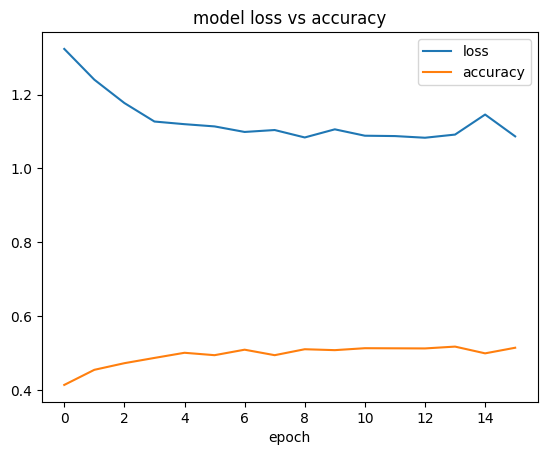

In [ ]:
pyplot.plot(history.history['val_loss'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model loss vs accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'accuracy'], loc='upper right')
pyplot.show()

In [ ]:
predictions = model.predict(X_test)
predictions

101/101 [==============================] - 3s 28ms/step


array([[6.0763615e-03, 8.9917462e-03, 7.6590389e-02, 3.6561817e-01,
        5.4272336e-01],
       [2.1253293e-02, 1.7067678e-01, 5.8581609e-01, 1.9727905e-01,
        2.4974789e-02],
       [2.5500623e-03, 1.5481868e-02, 2.0604737e-01, 5.3528887e-01,
        2.4063183e-01],
       ...,
       [7.2819093e-04, 3.8339423e-03, 9.4944589e-02, 6.0011083e-01,
        3.0038255e-01],
       [2.3342501e-03, 5.1446055e-04, 3.5608481e-03, 9.3453750e-02,
        9.0013671e-01],
       [9.7714690e-04, 6.0322543e-04, 1.3912452e-02, 3.2939139e-01,
        6.5511578e-01]], dtype=float32)

In [ ]:
predicted_classes = []
for softmax_probabilities in predictions:
    predicted_class = np.argmax(softmax_probabilities)+1
    predicted_classes.append(predicted_class)

In [ ]:
i = 0

for i in range(0, len(Y_test)):
    Y_test[i] = Y_test[i] + 1

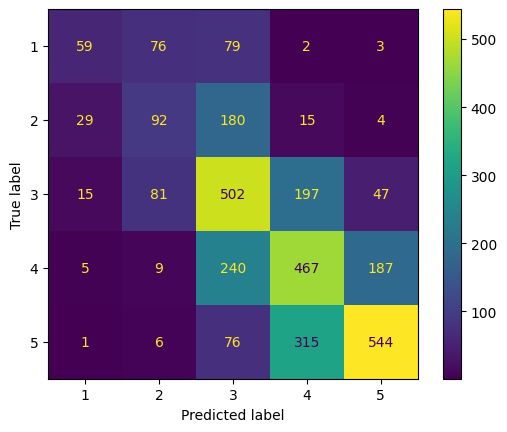

In [ ]:
cm = confusion_matrix(Y_test, predicted_classes, labels=[1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
disp.plot()
plt.show()

In [ ]:
#here I create a 3d tensor with integer encoding for the model with the keras embedding layer

j = 0
i = 0
rev_l300 = np.zeros((len(model_reviews)-count_l300, 304, 1), dtype=float)
count = 0

for j in range(0, len(model_reviews)):
  k = 0
  if len(model_reviews.loc[j].Review_Text) <= 300:
    for k in range(0, len(model_reviews.loc[j].Review_Text)):
      rev_l300[count][k][0:256] = int(model_reviews.loc[j].Review_Text[k])

    rev_l300[count][300] = float(model_reviews.loc[j].Reviewer_Location)
    rev_l300[count][301] = float(model_reviews.loc[j].Branch)
    rev_l300[count][302] = float(model_reviews.loc[j].Year)
    rev_l300[count][303] = float(model_reviews.loc[j].Month)
    count += 1
  if j%1000 == 0:
      print(j/1000, end = " ")

0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 

In [ ]:
X = rev_l300
y = rating_arr_np
# Reshape the 3D tensor into a 2D matrix
X_2D = X.reshape(X.shape[0], -1)

# Split the dataset while maintaining class balance
X_train_n, X_test_n, Y_train_n, Y_test_n = train_test_split(X_2D, y, test_size=0.2, stratify=y)

# Reshape the training and testing subsets back to 3D tensors
X_train_n = X_train_n.reshape(X_train_n.shape[0], X.shape[1], X.shape[2])
X_test_n = X_test_n.reshape(X_test_n.shape[0], X.shape[1], X.shape[2])

In [ ]:
from keras.layers import Embedding

model_n = keras.Sequential(
    [
        Embedding(42591, 256, input_length=304),
        #Bidirectional(GRU(64, return_sequences=True, dropout = 0.2, recurrent_dropout = 0.2)),
        #GRU(32, dropout = 0.2, recurrent_dropout = 0.2),
        Bidirectional(GRU(32, dropout = 0.2, recurrent_dropout = 0.2)),
        Dropout(0.15),
        Dense(256, activation="sigmoid", kernel_initializer="glorot_uniform"),
        Dense(128, activation="sigmoid", kernel_initializer="glorot_uniform"),
        Dense(5, activation="softmax"),
    ]
)


model_n.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=10**-3),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

print(model_n.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 304, 256)          10903296  
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               55680     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 256)               16640     
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 5)                 645       
                                                      

In [ ]:
batch_size = 16
epochs = 8
history_n = model_n.fit(x=X_train_n,y=Y_train_n,
        epochs=epochs,
        batch_size = batch_size,
        shuffle=True,
        validation_data=(X_test_n, Y_test_n))

Epoch 1/8
808/808 [==============================] - 236s 289ms/step - loss: 1.3264 - accuracy: 0.4048 - val_loss: 1.2157 - val_accuracy: 0.4376
Epoch 2/8
808/808 [==============================] - 278s 344ms/step - loss: 1.0955 - accuracy: 0.5082 - val_loss: 1.1333 - val_accuracy: 0.4955
Epoch 3/8
808/808 [==============================] - 265s 328ms/step - loss: 0.9362 - accuracy: 0.5875 - val_loss: 1.2129 - val_accuracy: 0.4930
Epoch 4/8
808/808 [==============================] - 261s 323ms/step - loss: 0.7951 - accuracy: 0.6614 - val_loss: 1.2566 - val_accuracy: 0.5054
Epoch 5/8
808/808 [==============================] - 246s 305ms/step - loss: 0.6603 - accuracy: 0.7352 - val_loss: 1.3429 - val_accuracy: 0.5020
Epoch 6/8
808/808 [==============================] - 231s 286ms/step - loss: 0.5382 - accuracy: 0.7960 - val_loss: 1.5455 - val_accuracy: 0.4952
Epoch 7/8
808/808 [==============================] - 229s 283ms/step - loss: 0.4407 - accuracy: 0.8421 - val_loss: 1.7171 - val_ac

In [ ]:
model_n.save_weights('./model_weights_new_2.h5')

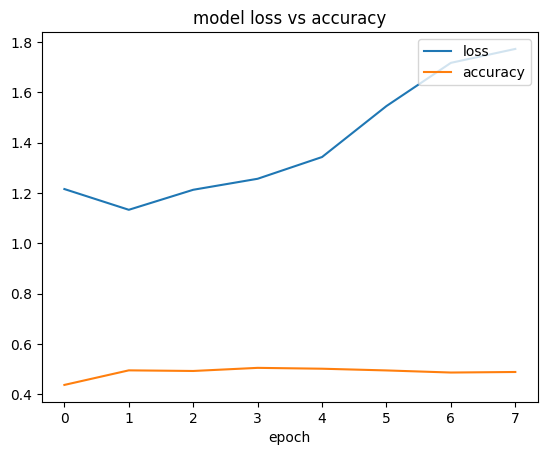

In [ ]:
pyplot.plot(history_n.history['val_loss'])
pyplot.plot(history_n.history['val_accuracy'])
pyplot.title('model loss vs accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'accuracy'], loc='upper right')
pyplot.show()

In [ ]:
predictions_n = model_n.predict(X_test_n)
predictions_n

101/101 [==============================] - 3s 24ms/step


array([[6.3422980e-05, 2.4922675e-04, 2.1380682e-03, 1.0628968e-01,
        8.9125955e-01],
       [6.4810715e-04, 3.3221699e-03, 2.2994791e-01, 7.4643970e-01,
        1.9642092e-02],
       [2.1254239e-04, 9.4975054e-04, 1.3417753e-02, 5.4089540e-01,
        4.4452453e-01],
       ...,
       [2.1372335e-04, 9.6163870e-04, 1.3117921e-02, 5.2548426e-01,
        4.6022245e-01],
       [4.4868761e-05, 1.7112371e-04, 1.3692724e-03, 7.0374168e-02,
        9.2804056e-01],
       [7.5085508e-04, 1.1400322e-02, 9.5315558e-01, 3.3335544e-02,
        1.3577265e-03]], dtype=float32)

In [ ]:
predicted_classes_n = []
for softmax_probabilities in predictions_n:
    predicted_class = np.argmax(softmax_probabilities)+1
    predicted_classes_n.append(predicted_class)

In [ ]:
i = 0

for i in range(0, len(Y_test_n)):
    Y_test_n[i] = Y_test_n[i] + 1

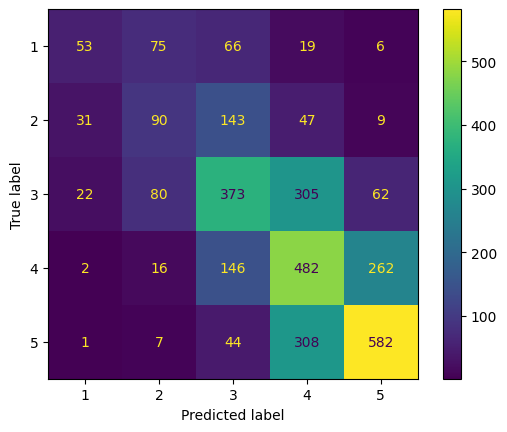

In [ ]:
cm = confusion_matrix(Y_test_n, predicted_classes_n, labels=[1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
disp.plot()
plt.show()
